## 0. Import libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1. Load Data

In [2]:
df = pd.read_csv('./kospi.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6776,2024-06-13,2764.179932,2776.719971,2752.610107,2754.889893,2754.889893,700000
6777,2024-06-14,2759.219971,2769.159912,2750.860107,2758.419922,2758.419922,645000
6778,2024-06-17,2754.830078,2759.860107,2741.030029,2744.100098,2744.100098,594000
6779,2024-06-18,2765.699951,2772.350098,2759.030029,2763.919922,2763.919922,561500
6780,2024-06-19,0.000000,0.000000,0.000000,2797.330078,2797.330078,0


In [3]:
df['kospi_shift'] = df['Adj Close'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,kospi_shift
0,1996-12-11,705.989990,709.479980,704.429993,704.679993,704.679993,28000,689.380005
1,1996-12-12,705.109985,706.010010,688.739990,689.380005,689.380005,25900,689.070007
2,1996-12-13,690.440002,695.719971,677.640015,689.070007,689.070007,26500,673.919983
3,1996-12-16,686.969971,686.969971,667.710022,673.919983,673.919983,22800,663.349976
4,1996-12-17,675.349976,680.090027,660.390015,663.349976,663.349976,31600,661.390015


In [4]:
col_names = df.columns.values
print(col_names)

['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'kospi_shift']


In [5]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [6]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,Open,High,Low,Close,Adj Close,Volume,kospi_shift
mean,1569.124231,1578.705971,1557.237184,1568.338071,1568.338071,4.353783e+05,1568.605173
var,516814.859199,518981.905020,513112.003376,516172.978504,516172.978504,7.413245e+10,516171.059570
max,3305.459961,3316.080078,3295.439941,3305.209961,3305.209961,3.455500e+06,3305.209961
min,283.410004,291.010010,277.369995,280.000000,280.000000,1.390000e+04,280.000000


In [7]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,Open,High,Low,Close,Adj Close,Volume,kospi_shift
6776,0.820890,0.821703,0.820140,0.818089,0.818089,0.199355,0.819256
6777,0.819249,0.819204,0.819560,0.819256,0.819256,0.183374,0.814522
6778,0.817796,0.816130,0.816303,0.814522,0.814522,0.168555,0.821074
6779,0.821393,0.820259,0.822267,0.821074,0.821074,0.159112,0.832117
6780,-0.093781,-0.096199,-0.091903,0.832117,0.832117,-0.004039,NaN


In [8]:
train_x = np.zeros([(len(train_data) - 64 + 1), 64])
test_x = np.zeros([(len(test_data) - 64 + 1), 64])
train_x.shape, test_x.shape

((6378, 64), (277, 64))

In [9]:
class StockDataset(Dataset):
    def __init__(self, y, seq_len, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        seq_iter = num_samples - seq_len + 1
        # print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        # X = np.zeros([input_window, num_samples])
        # Y = np.zeros([output_window, num_samples])
        X = np.zeros([num_samples, input_window])
        X_FFT = np.zeros([num_samples, input_window])
        Y = np.zeros([num_samples, output_window])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :] = y[start_x:end_x]
            ft = np.fft.fftn(y[start_x:end_x], norm='forward')
            X_FFT[i, :] = abs(ft)

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = y[end_x: end_x + output_window]
        print(X.shape, Y.shape)
        print(X[-1, -1], '\n', Y[0])
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))

        start_pos = num_samples % seq_len
        seq_iter = seq_iter - start_pos - 1
        X_ = np.zeros([seq_iter, seq_len, 2, input_window])
        Y_ = np.zeros([seq_iter, output_window])
        print('start pos:', start_pos, 'seq_iter:', seq_iter)
        for i in range(seq_iter):
            X_[i, :, 0, :] = X[(start_pos+i):(start_pos+seq_len+i), :]
            X_[i, :, 1, :] = X_FFT[(start_pos+i):(start_pos+seq_len+i), :]
            Y_[i, :] = Y[start_pos+seq_len+i-1, :]
            # print('i:', i, 'index start:', start_pos+i, 'index end:', start_pos+seq_len+i)
        # X_[0, :, :] = X[(start_pos+0*seq_len):(start_pos+(0+1)*seq_len), :]
        # Y_[0, :] = Y[start_pos+0*seq_len, :]
        print(X[(start_pos+i):(start_pos+seq_len+i), :].shape)
        print(X_.shape, Y_.shape)
        self.x = X_
        self.y = Y_
        
        self.len = len(X_)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

[1.31988255e-01 3.12271658e-03 1.29683371e-03 2.35780424e-03
 2.80902610e-03 9.73406883e-04 1.45464698e-03 7.41390180e-04
 5.13405540e-04 5.54392750e-04 6.60125892e-04 3.03655271e-04
 7.31274817e-04 4.41558934e-04 1.01014959e-04 1.81445632e-04
 5.30915635e-04 4.19992340e-04 5.34497679e-04 1.23551995e-04
 2.60700292e-04 7.37847060e-05 3.18493456e-04 3.70558504e-04
 1.07783208e-04 1.47474140e-04 1.16297853e-04 2.22296420e-04
 3.64346220e-04 1.53758572e-04 3.54410473e-04 3.88272864e-04
 1.69404937e-05 3.88272864e-04 3.54410473e-04 1.53758572e-04
 3.64346220e-04 2.22296420e-04 1.16297853e-04 1.47474140e-04
 1.07783208e-04 3.70558504e-04 3.18493456e-04 7.37847060e-05
 2.60700292e-04 1.23551995e-04 5.34497679e-04 4.19992340e-04
 5.30915635e-04 1.81445632e-04 1.01014959e-04 4.41558934e-04
 7.31274817e-04 3.03655271e-04 6.60125892e-04 5.54392750e-04
 5.13405540e-04 7.41390180e-04 1.45464698e-03 9.73406883e-04
 2.80902610e-03 2.35780424e-03 1.29683371e-03 3.12271658e-03] 0.17346486151359236


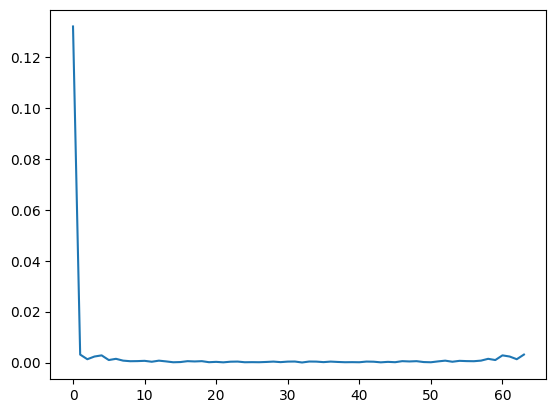

In [10]:
aa = train_data.loc[:63, 'Adj Close']
aa_ft = np.fft.fftn(aa, norm='forward')
print(abs(aa_ft), np.sum(abs(aa_ft)))
plt.plot(abs(aa_ft))
plt.show()

In [11]:
train_x = StockDataset(train_data['Adj Close'], 64, 64, 1, 1)
print('length of data', len(train_x))
print(next(iter(train_x))[1])

(6377, 64) (6377, 1)
0.7285510916565385 
 [0.12107919]
start pos: 41 seq_iter: 6272
(64, 64)
(6272, 64, 2, 64) (6272, 1)
length of data 6272
[0.15411492]


### 3. create dataloader

In [12]:
train_dataset = StockDataset(train_data['Adj Close'], 64, 64, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['Adj Close'], 64, 64, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(next(iter(test_dataset)))

(6377, 64) (6377, 1)
0.7285510916565385 
 [0.12107919]
start pos: 41 seq_iter: 6272
(64, 64)
(6272, 64, 2, 64) (6272, 1)
(276, 64) (276, 1)
0.8210735631404716 
 [0.73429611]
start pos: 20 seq_iter: 192
(64, 64)
(192, 64, 2, 64) (192, 1)
98 6272 (64, 2, 64) (1,)


In [13]:
for x1, y1 in train_dataloader:
    pass
print(x1[0], '\n', y1[63])

tensor([[[0.5043, 0.5161, 0.5196,  ..., 0.4040, 0.4001, 0.4013],
         [0.4475, 0.0193, 0.0106,  ..., 0.0059, 0.0106, 0.0193]],

        [[0.5161, 0.5196, 0.5182,  ..., 0.4001, 0.4013, 0.3947],
         [0.4458, 0.0184, 0.0114,  ..., 0.0053, 0.0114, 0.0184]],

        [[0.5196, 0.5182, 0.5089,  ..., 0.4013, 0.3947, 0.3948],
         [0.4439, 0.0175, 0.0121,  ..., 0.0045, 0.0121, 0.0175]],

        ...,

        [[0.4040, 0.4001, 0.4013,  ..., 0.2210, 0.2392, 0.2281],
         [0.3288, 0.0365, 0.0025,  ..., 0.0097, 0.0025, 0.0365]],

        [[0.4001, 0.4013, 0.3947,  ..., 0.2392, 0.2281, 0.2325],
         [0.3261, 0.0367, 0.0021,  ..., 0.0109, 0.0021, 0.0367]],

        [[0.4013, 0.3947, 0.3948,  ..., 0.2281, 0.2325, 0.2478],
         [0.3237, 0.0369, 0.0036,  ..., 0.0118, 0.0036, 0.0369]]],
       dtype=torch.float64) 
 tensor([0.1603], dtype=torch.float64)


In [14]:
for x1, y1 in test_dataloader:
    pass
print(x1[0].shape, '\n', y1[0].shape)

torch.Size([64, 2, 64]) 
 torch.Size([1])


## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

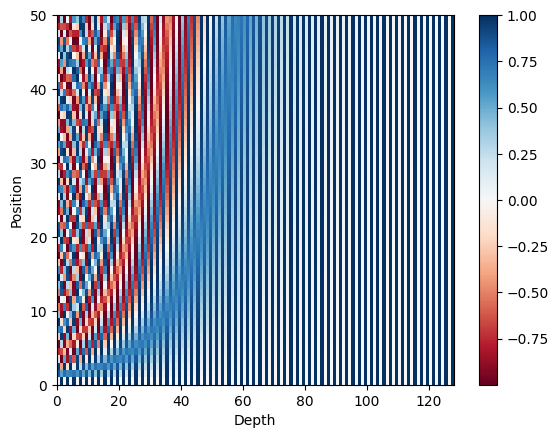

In [16]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [17]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print(q.size(), k_t.size())
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [19]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

### e. Layer Normalization

In [20]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [21]:
class LinearEmbedding(nn.Module):
    def __init__(self, in_d, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.in_d = in_d
        print(type(in_d), type(d_model))
        self.linear1 = nn.Linear(in_d, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.normal1 = LayerNorm(d_model//2)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 1]
        output: [batch_size, seq_len, d_model]
        '''
        if self.in_d == self.d_model:
            return x
        else:
            x = self.linear1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.normal1(x)
            x = self.linear2(x)
            x = self.relu(x)
            return x


In [22]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, in_d, dropout, d_model, seq_len, device):
        # in_d, dropout, d_model, seq_len, device
        super().__init__()
        self.in_d = in_d
        self.d_model = d_model
        self.lin_emb = LinearEmbedding(in_d, dropout, d_model)
        # self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        if self.in_d == self.d_model:
            lin_emb = x
        else:
            lin_emb = self.lin_emb(x)
        # pos_emb = self.pos_emb(x)
        # print(pos_emb.size(), lin_emb.size())
        return self.dropout(lin_emb)
        # return self.dropout(lin_emb + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.normal1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        self.normal2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [24]:
class Encoder(nn.Module):
    def __init__(self, in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        # in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        super().__init__()
        self.emb = TrnasformerEmbedding(in_d, dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [25]:
class TransformerEncoder(nn.Module):
    def __init__(self, in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device):
        super().__init__()
        self.encoder1 = Encoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        self.encoder2 = Encoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        # self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(d_model, lstm_hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        # self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(lstm_hidden_size, lstm_hidden_size//2)
        self.linear2 = nn.Linear(lstm_hidden_size//2, 1)
        self.normal1 = nn.LayerNorm(lstm_hidden_size//2)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # print('model dimention', x.size())
        # print('encode input0 dim', x[:, :, 0, :].squeeze().size())
        # print('encode input1 dim', x[:, :, 1, :].squeeze().size())
        x_t = self.encoder1(x[:, :, 0, :].squeeze())
        x_fft = self.encoder2(x[:, :, 1, :].squeeze())
        xs = x_t + x_fft
        lstm_out, (hs, cs) = self.lstm(xs)
        # print('lstm out dim', lstm_out[:, -1, :].size())
        out = lstm_out[:, -1, :]
        # x = self.flatten(out)
        # print('flatten out', x.size())
        x = self.linear1(out)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.normal1(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

## 9. model, loss_fn, optimizer


In [26]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, _, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_d = 64
model_d = 512
dropout = 0
ffn_hidden = model_d * 2
n_layers = 4
n_head = 4
lstm_hidden_size = model_d * 2
lstm_layers = 1
lr_sched = True
lr = 1e-5

64 64 64


In [27]:
model = TransformerEncoder(in_d, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = lr)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.3)

<class 'int'> <class 'int'>
<class 'int'> <class 'int'>


In [28]:
model

TransformerEncoder(
  (encoder1): Encoder(
    (emb): TrnasformerEmbedding(
      (lin_emb): LinearEmbedding(
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0, inplace=False)
        (normal1): LayerNorm()
      )
      (dropout): Dropout(p=0, inplace=False)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (normal1): LayerNorm()
        (dropout1): Dropout(p=0, inplace=False)
        (ffn): 

## 10. Train and Test function

In [29]:
type(in_d)

int

In [30]:
linear_model = LinearEmbedding(in_d, dropout, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = linear_model(in_x)
out.size()

<class 'int'> <class 'int'>


torch.Size([64, 64, 2, 512])

In [31]:
emb_model = TrnasformerEmbedding(in_d, dropout, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
print(in_x.shape, in_y.shape)
out = emb_model(in_x[:, :, 0, :].squeeze())
out.size()

<class 'int'> <class 'int'>
torch.Size([64, 64, 2, 64]) torch.Size([64, 1])


torch.Size([64, 64, 512])

In [32]:
encoder_model = Encoder(in_d, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x[:, :, 0, :].squeeze())
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

<class 'int'> <class 'int'>
torch.Size([64, 64, 512])
torch.Size([64, 1])
torch.Size([64])


In [33]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [34]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        # print(output, labels)
        loss = loss_fn(output.squeeze().float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 9))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 2.295419, lr:  1e-05
epochs: 1, loss: 0.038998, lr:  1e-05
epochs: 2, loss: 0.027743, lr:  1e-05
epochs: 3, loss: 0.024243, lr:  1e-05
epochs: 4, loss: 0.021443, lr:  1e-05
epochs: 5, loss: 0.018847, lr:  1e-05
epochs: 6, loss: 0.018823, lr:  1e-05
epochs: 7, loss: 0.017566, lr:  1e-05
epochs: 8, loss: 0.023332, lr:  1e-05
epochs: 9, loss: 0.027591, lr:  1e-05
epochs: 10, loss: 0.018550, lr:  1e-05
epochs: 11, loss: 0.025180, lr:  1e-05
epochs: 12, loss: 0.017206, lr:  1e-05
epochs: 13, loss: 0.014024, lr:  1e-05
epochs: 14, loss: 0.025011, lr:  1e-05
epochs: 15, loss: 0.017085, lr:  1e-05
epochs: 16, loss: 0.020892, lr:  1e-05
epochs: 17, loss: 0.020477, lr:  1e-05
epochs: 18, loss: 0.016289, lr:  1e-05
epochs: 19, loss: 0.020849, lr:  1e-05
epochs: 20, loss: 0.023663, lr:  1e-05
epochs: 21, loss: 0.055109, lr:  1e-05
epochs: 22, loss: 0.022912, lr:  1e-05
epochs: 23, loss: 0.028836, lr:  1e-05
epochs: 24, loss: 0.017992, lr:  1e-05
epochs: 25, loss: 0.015008, lr:  1e

In [35]:
save_path = 'fft_patch_tst_kospi_only_1970_window_flatten_modeld_' + str(model_d) + '_seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
print(save_path)
df_loss

fft_patch_tst_kospi_only_1970_window_flatten_modeld_512_seqlen64_layaers4_nhead4.pt


,epoch,loss
0,0.0,2.295419
1,1.0,0.038998
2,2.0,0.027743
3,3.0,0.024243
4,4.0,0.021443
...,...,...
995,995.0,0.002631
996,996.0,0.002635
997,997.0,0.002604
998,998.0,0.002619


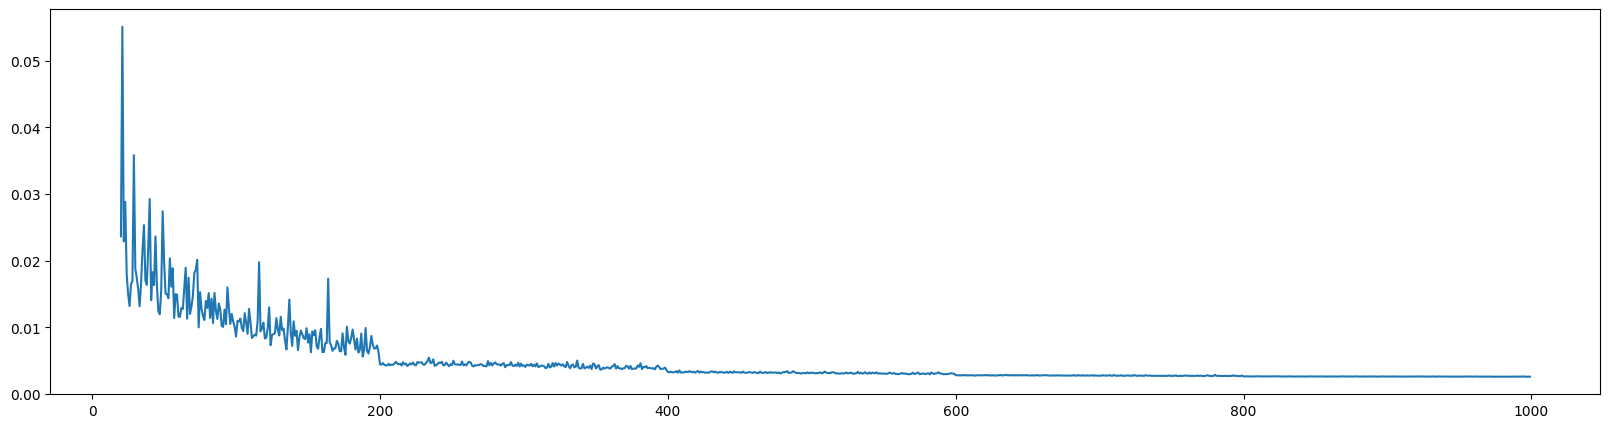

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [37]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'Adj Close']
max = scale_params.loc['max', 'Adj Close']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0]]
            num += 1

In [38]:
test_result

,pred,pred_rescale,real
0,0.752633,2556.872053,2563.709961
1,0.754541,2562.645069,2584.550049
2,0.758734,2575.329077,2582.179932
3,0.759191,2576.713367,2563.340088
4,0.754433,2562.319236,2548.260010
...,...,...,...
187,0.797049,2691.240892,2728.169922
188,0.803679,2711.297684,2754.889893
189,0.811418,2734.709807,2758.419922
190,0.816110,2748.903245,2744.100098


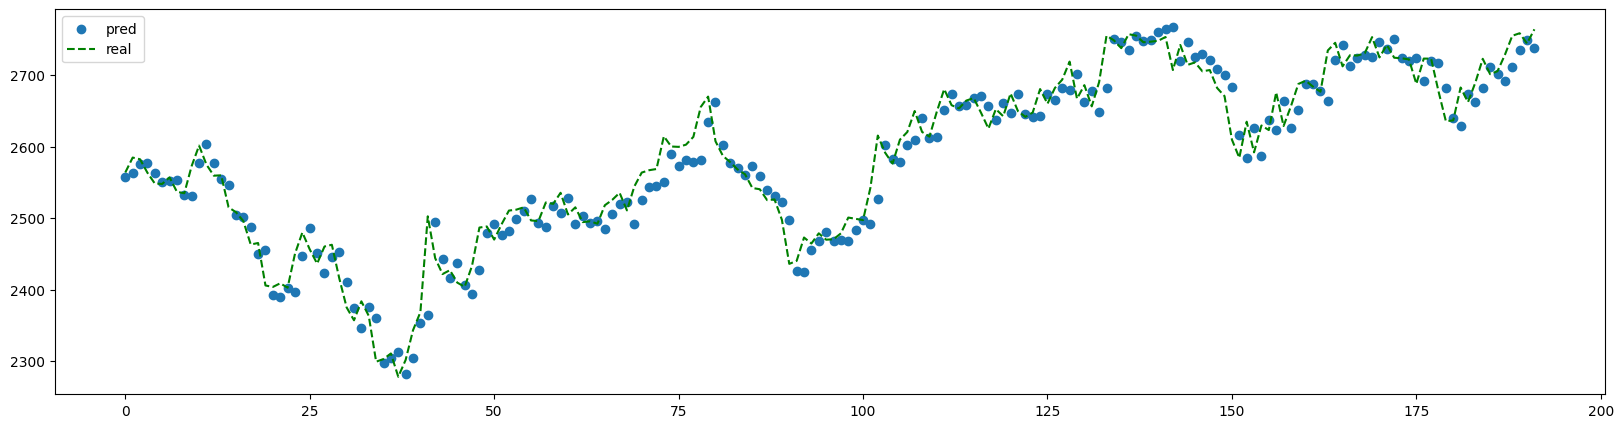

In [39]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

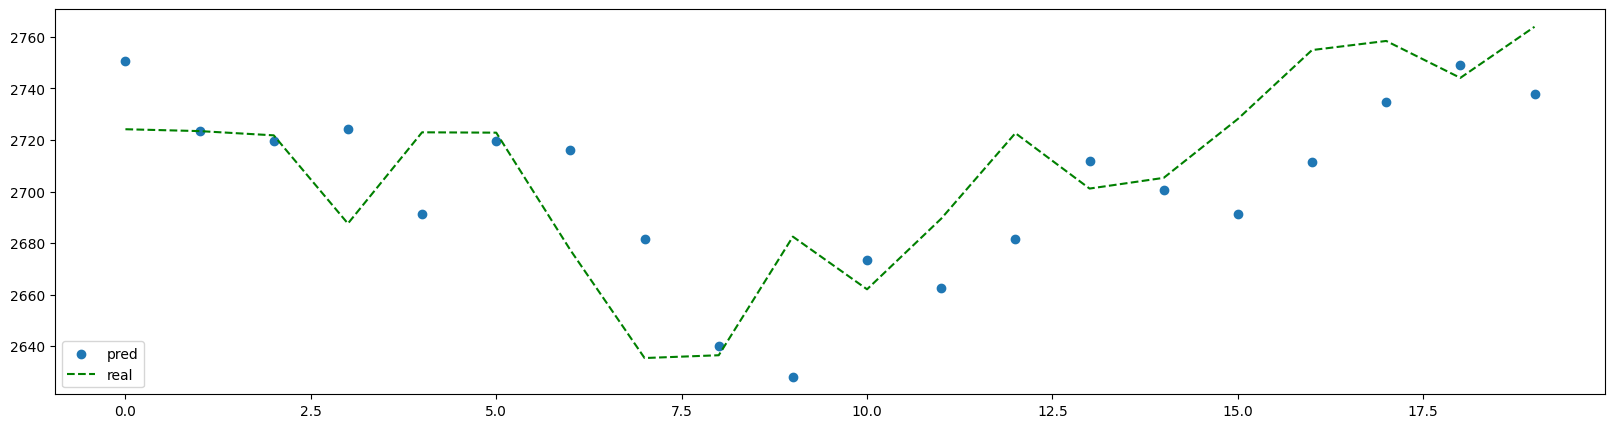

In [40]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

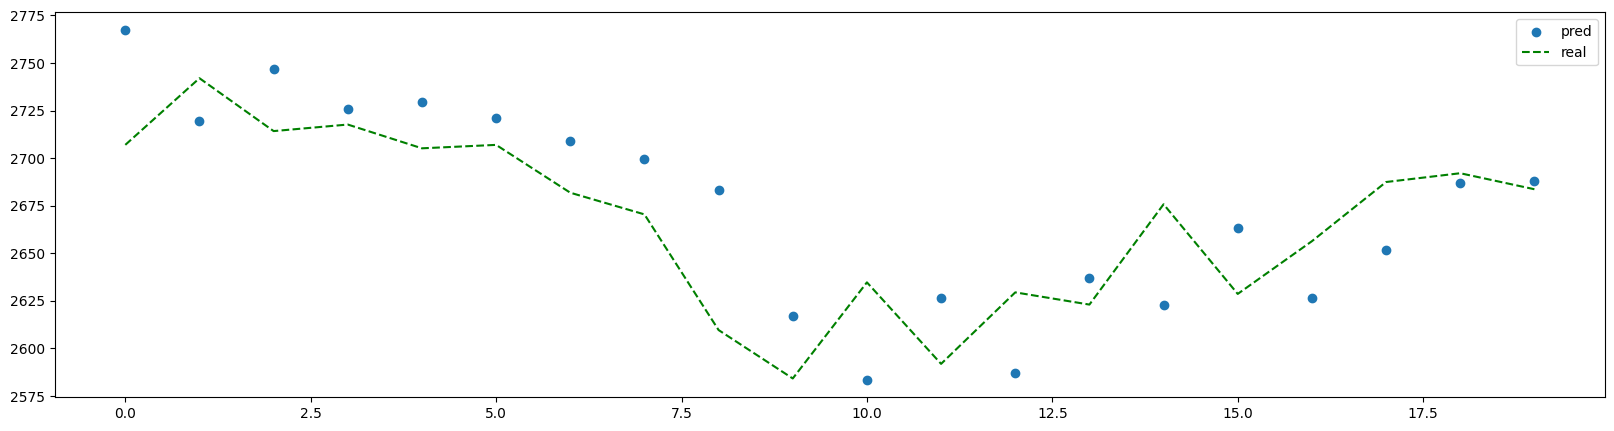

In [41]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [42]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.718868,2454.725244,2405.689941,2479.442317,2525.561362,2532.064198,2467.523975,2514.753979,2536.915479,2507.587405,2523.358359,2532.064198,2496.045873,2515.492137,2526.303578
20,0.698203,2392.211474,2403.600098,2457.110868,2507.139789,2521.675657,2446.618018,2494.985986,2528.909985,2487.930813,2509.573106,2521.675657,2480.295891,2503.730820,2517.188917
21,0.697489,2390.051823,2408.729980,2434.813174,2485.770130,2512.152296,2429.212012,2478.386987,2520.118982,2471.316701,2497.185805,2512.152296,2468.148197,2493.884841,2509.341602
22,0.701303,2401.588837,2402.580078,2417.696155,2468.241828,2504.345797,2417.134033,2462.723999,2511.138989,2459.517279,2487.402601,2504.345797,2457.052691,2484.540893,2501.803545
23,0.699742,2396.867428,2450.080078,2407.088961,2452.455004,2496.927650,2414.136035,2451.758008,2505.475989,2448.942617,2478.242106,2496.927650,2455.875785,2481.054092,2498.233596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.797049,2691.240892,2728.169922,2689.642097,2678.775752,2689.465128,2709.365967,2684.070996,2704.685010,2689.274069,2692.072939,2689.465128,2700.162125,2698.613041,2693.440037
188,0.803679,2711.297684,2754.889893,2699.350630,2678.292216,2690.504876,2722.443945,2691.829980,2705.912500,2692.944671,2693.820644,2690.504876,2709.283419,2703.729119,2696.366510
189,0.811418,2734.709807,2758.419922,2709.970302,2683.604161,2692.610071,2729.593945,2704.127979,2706.183496,2699.905527,2697.537840,2692.610071,2717.472836,2708.701010,2699.321713
190,0.816110,2748.903245,2744.100098,2717.388706,2694.486140,2695.290939,2738.179980,2714.885986,2707.157495,2708.071813,2702.207423,2695.290939,2721.910713,2711.919109,2701.454208


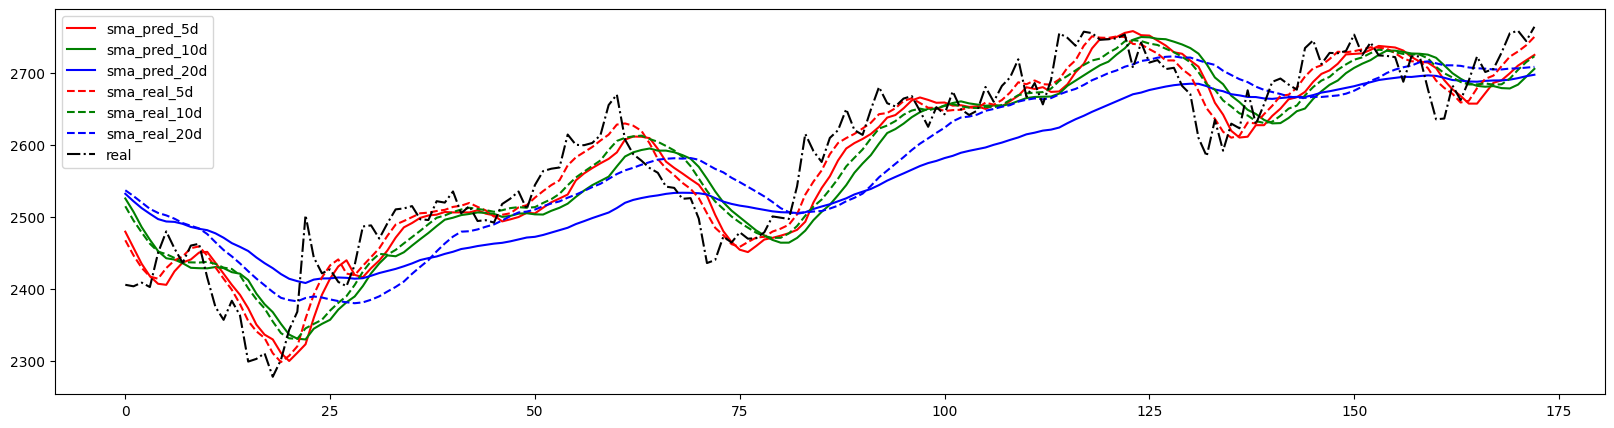

In [43]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

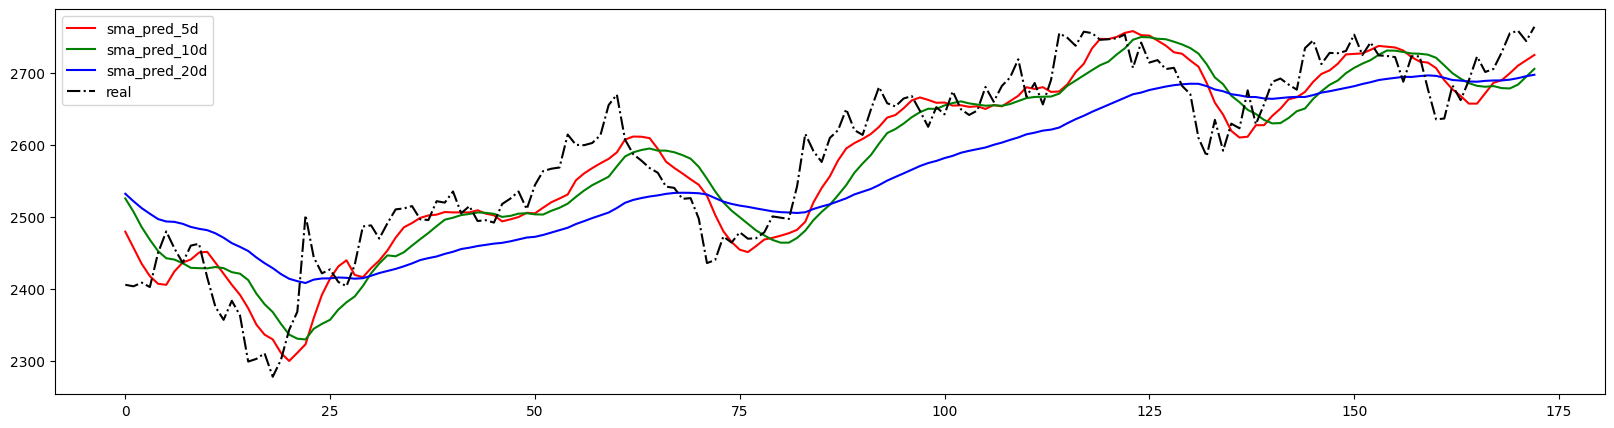

In [44]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

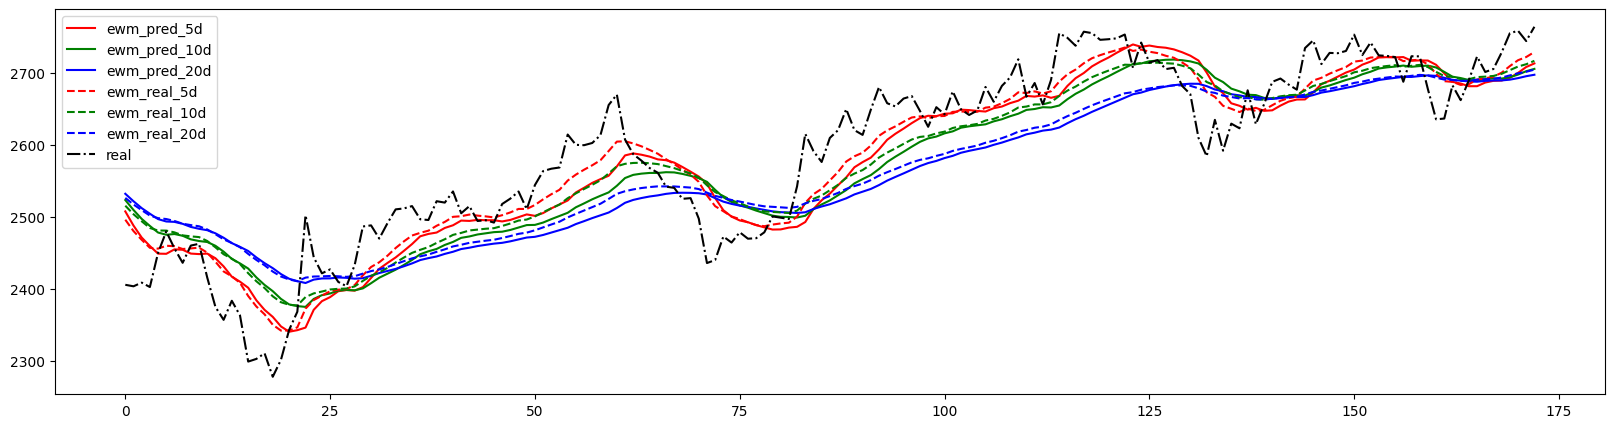

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [46]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 940.9947, MAPE: 0.0092


In [48]:
test_result.tail(6)

,pred,pred_rescale,real
186,0.800206,2700.791900,2705.320068
187,0.797049,2691.240892,2728.169922
188,0.803679,2711.297684,2754.889893
189,0.811418,2734.709807,2758.419922
190,0.816110,2748.903245,2744.100098
191,0.812478,2737.916196,2763.919922


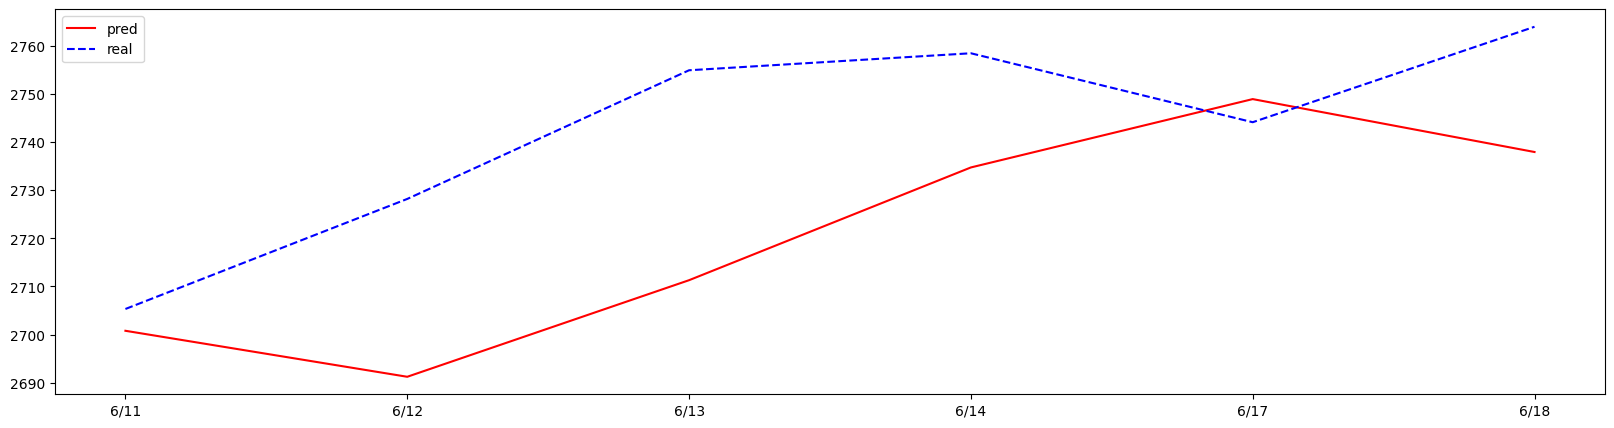

In [51]:
date = ['6/11', '6/12', '6/13', '6/14', '6/17', '6/18']
plt.figure(figsize=(20, 5))
plt.plot(date, test_result.iloc[-6: , 1], 'r-', label='pred')
plt.plot(date, test_result.iloc[-6: , 2], 'b--', label='real')
plt.legend()
plt.show()

In [50]:
test_result['real'].tail(6) - test_result['pred_rescale'].tail(6)

186     4.528168
187    36.929030
188    43.592208
189    23.710115
190    -4.803147
191    26.003726
dtype: float64